# Tunneling to kaggle, we have to install popper-utils

In [2]:
!apt-get install -y poppler-utils
!pip install -q cohere

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpoppler-dev libpoppler-private-dev libpoppler118
The following NEW packages will be installed:
  poppler-utils
The following packages will be upgraded:
  libpoppler-dev libpoppler-private-dev libpoppler118
3 upgraded, 1 newly installed, 0 to remove and 84 not upgraded.
Need to get 1,462 kB of archives.
After this operation, 700 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpoppler-private-dev amd64 22.02.0-2ubuntu0.8 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpoppler-dev amd64 22.02.0-2ubuntu0.8 [5,186 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpoppler118 amd64 22.02.0-2ubuntu0.8 [1,072 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 1,46

In [3]:
import os
import asyncio
from concurrent.futures import ThreadPoolExecutor
from pdf2image import convert_from_path
from PIL import Image
import io
import base64
import tqdm
import cohere
import aiohttp
import glob
import numpy as np
from tqdm.asyncio import tqdm



# Use asynchronous programming to read the pdf files in parallel

In [4]:
async def compress_and_save_image(image, filepath, quality=85, optimize=True):
    def _compress_save(img=image):  # pass image explicitly
        if img.mode in ('RGBA', 'LA', 'P'):
            background = Image.new('RGB', img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[-1])
            img = background
        else:
            img = img.convert('RGB')

        img.save(filepath, 'JPEG', quality=quality, optimize=optimize, progressive=True)
        return os.path.getsize(filepath)

    loop = asyncio.get_event_loop()
    with ThreadPoolExecutor() as executor:
        return await loop.run_in_executor(executor, _compress_save)


async def convert_pdf_to_compressed_images(pdf_path, output_dir="economic_survey_images", 
                                         dpi=150, quality=85):
    """Convert PDF to compressed images asynchronously"""
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Converting PDF: {pdf_path}")
    print(f"Output directory: {output_dir}")
    
    # Convert PDF to images (reduce DPI for smaller file size)
    def _convert_pdf():
        return convert_from_path(pdf_path, dpi=dpi, output_folder=output_dir)
    
    loop = asyncio.get_event_loop()
    with ThreadPoolExecutor() as executor:
        images = await loop.run_in_executor(executor, _convert_pdf)
    
    print(f"Converted {len(images)} pages")
    
    # Create tasks for compressing and saving all images concurrently
    tasks = []
    for i, image in enumerate(images):
        filepath = os.path.join(output_dir, f'page_{i+1:03d}.jpg')  # Use .jpg extension
        task = compress_and_save_image(image, filepath, quality=quality)
        tasks.append(task)
    
    # Execute all compression tasks concurrently
    print("Compressing and saving images...")
    file_sizes = await asyncio.gather(*tasks)
    
    # Report results
    total_size = sum(file_sizes)
    avg_size = total_size / len(file_sizes) if file_sizes else 0
    
    print(f"Conversion complete!")
    print(f"Total files: {len(file_sizes)}")
    print(f"Total size: {total_size / (1024*1024):.2f} MB")
    print(f"Average size per image: {avg_size / 1024:.2f} KB")
    
    return len(images), total_size

# Main execution
async def main():
    pdf_path = "/kaggle/input/knbs-real-estate/2023-24-Real-Estate-Survey-Report_1.pdf"
    
    await convert_pdf_to_compressed_images(
        pdf_path=pdf_path,
        output_dir="real_estate_images",
        dpi=150,
        quality=85
    )

# Run the async function
if __name__ == "__main__":
    await main()

Converting PDF: /kaggle/input/knbs-real-estate/2023-24-Real-Estate-Survey-Report_1.pdf
Output directory: real_estate_images
Converted 60 pages
Compressing and saving images...
Conversion complete!
Total files: 60
Total size: 11.87 MB
Average size per image: 202.61 KB


# Set up cohere

In [5]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
cohere_api_key = user_secrets.get_secret("COHERE_API_KEY")
openrouter_api_key = user_secrets.get_secret("OPENROUTER_API_KEY")


In [4]:

co = cohere.ClientV2(api_key=os.environ["cohere"])

In [5]:
max_pixels = 1568*1568  #Max resolution for images

def resize_image(pil_image):
    org_width, org_height = pil_image.size

    # Resize image if too large
    if org_width * org_height > max_pixels:
        scale_factor = (max_pixels / (org_width * org_height)) ** 0.5
        new_width = int(org_width * scale_factor)
        new_height = int(org_height * scale_factor)
        pil_image.thumbnail((new_width, new_height))

# Convert images to a base64 string before sending it to the API
def base64_from_image(img_path):
    pil_image = Image.open(img_path)
    img_format = pil_image.format if pil_image.format else "PNG"

    resize_image(pil_image)

    with io.BytesIO() as img_buffer:
        pil_image.save(img_buffer, format=img_format)
        img_buffer.seek(0)
        img_data = f"data:image/{img_format.lower()};base64,"+base64.b64encode(img_buffer.read()).decode("utf-8")

    return img_data



In [6]:
os.listdir("/kaggle/working/real_estate_images")[:10]

['496b0fd4-6dc7-424b-8687-ebf2f7a505e5-08.ppm',
 'page_052.jpg',
 '496b0fd4-6dc7-424b-8687-ebf2f7a505e5-35.ppm',
 '496b0fd4-6dc7-424b-8687-ebf2f7a505e5-25.ppm',
 '496b0fd4-6dc7-424b-8687-ebf2f7a505e5-37.ppm',
 '496b0fd4-6dc7-424b-8687-ebf2f7a505e5-41.ppm',
 '496b0fd4-6dc7-424b-8687-ebf2f7a505e5-36.ppm',
 '496b0fd4-6dc7-424b-8687-ebf2f7a505e5-14.ppm',
 '496b0fd4-6dc7-424b-8687-ebf2f7a505e5-13.ppm',
 'page_042.jpg']

In [7]:
for file in os.listdir("/kaggle/working/real_estate_images"):
    if file.endswith(".ppm"):
        os.remove(os.path.join("/kaggle/working/real_estate_images", file))

# Use asynchronous programmning again tomake multiple calls to the cohere api to generate embeddings

In [8]:



# Config
BATCH_SIZE = 30  
CONCURRENT_REQUESTS = 8 
RATE_LIMIT_DELAY = 0.1  

img_folder = "/kaggle/working/real_estate_images"

async def process_batch_async(session, img_batch, semaphore):
    """Process a batch of images asynchronously"""
    async with semaphore:  # Limit concurrent requests
        try:
            # Prepare batch input
            api_inputs = []
            for img_path in img_batch:
                api_input_document = {
                    "content": [
                        {"type": "image", "image": base64_from_image(img_path)},
                    ]
                }
                api_inputs.append(api_input_document)

            # Prepare API call data
            payload = {
                "model": "embed-v4.0",
                "input_type": "search_document",
                "embedding_types": ["float"],
                "inputs": api_inputs
            }

            # Make async API call 
            api_response = co.embed(
                model="embed-v4.0",
                input_type="search_document",
                embedding_types=["float"],
                inputs=api_inputs,
            )

            # Extract embeddings
            batch_embeddings = [np.asarray(emb) for emb in api_response.embeddings.float]
            
            await asyncio.sleep(RATE_LIMIT_DELAY)  # Rate limiting
            return batch_embeddings, img_batch, None
            
        except Exception as e:
            return None, img_batch, str(e)

async def main_async():
    """Main async processing function"""
    # Get all images
    image_extensions = ['*.jpg', "*.png", "*.jpeg"]
    img_paths = []
    for extension in image_extensions:
        img_paths.extend(glob.glob(os.path.join(img_folder, extension)))
        img_paths.extend(glob.glob(os.path.join(img_folder, extension.upper())))

    print(f"Found {len(img_paths)} images")
    
    # Create batches
    img_batches = [img_paths[i:i + BATCH_SIZE] for i in range(0, len(img_paths), BATCH_SIZE)]
    print(f"Processing {len(img_batches)} batches with {CONCURRENT_REQUESTS} concurrent requests")

    # Semaphore to limit concurrent requests
    semaphore = asyncio.Semaphore(CONCURRENT_REQUESTS)
    
    doc_embeddings = []
    failed_batches = []
    
    # Create session for async requests
    async with aiohttp.ClientSession() as session:
        # Create all tasks
        tasks = [
            process_batch_async(session, batch, semaphore) 
            for batch in img_batches
        ]
        
        # Process all batches concurrently with progress bar
        results = await tqdm.gather(*tasks, desc="Processing batches")
        
        # Collect results
        for batch_embeddings, img_batch, error in results:
            if batch_embeddings is not None:
                doc_embeddings.extend(batch_embeddings)
            else:
                failed_batches.append((img_batch, error))
    
    return doc_embeddings, failed_batches


# Create the vector embeddings

In [9]:
doc_embeddings, failed_batches = await main_async()

print(f"Total embeddings extracted: {len(doc_embeddings)}")
if len(doc_embeddings) > 0:
    print(f"Shape of first embedding vector: {np.array(doc_embeddings[0]).shape}")
if failed_batches:
    print(f"Failed batches count: {len(failed_batches)}")
    for batch, error in failed_batches:
        print(f"Batch failed: {batch}, Error: {error}")


Found 60 images
Processing 2 batches with 8 concurrent requests


Processing batches: 100%|██████████| 2/2 [01:17<00:00, 38.88s/it]

Total embeddings extracted: 60
Shape of first embedding vector: (1536,)


In [10]:
img_paths = [os.path.join("real_estate_images", img) for img in os.listdir("real_estate_images")]

In [11]:
import requests
import json
import numpy as np
from PIL import Image
import base64
import io
import os

def search(question, max_img_size=800):
    # Compute the embedding for the query
    api_response = co.embed(
        model="embed-v4.0",
        input_type="search_query",
        embedding_types=["float"],
        texts=[question],
    )

    query_emb = np.asarray(api_response.embeddings.float[0])
    
    # Compute cosine similarities
    cos_sim_scores = np.dot(query_emb, np.asarray(doc_embeddings).T)

    # Get the most relevant image
    top_idx = np.argmax(cos_sim_scores)

    # Show the images
    print("Question:", question)

    hit_img_path = img_paths[top_idx]

    print("Most relevant image:", hit_img_path)
    image = Image.open(hit_img_path)
    max_size = (max_img_size, max_img_size)  # Adjust the size 
    image.thumbnail(max_size)
    display(image)
    return hit_img_path

def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Using Gemini 2.5 flash preview, it performed better than the microsoft-phi-multimodal-instruct
def answer(question, img_path, openrouter_api_key = os.getenv("openrouter")):
    # Encode the image to base64
    base64_image = encode_image_to_base64(img_path)
    
    # Determine the image format
    image_format = img_path.lower().split('.')[-1]
    if image_format == 'jpg':
        image_format = 'jpeg'
    
    prompt = f"""Answer the question based on the following image.
Don't use markdown.
Please provide enough context for your answer.

Question: {question}"""

    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {openrouter_api_key}",
            "Content-Type": "application/json",
            
        },
        data=json.dumps({
            "model": "google/gemini-2.5-flash-preview-05-20",
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": prompt
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/{image_format};base64,{base64_image}"
                            }
                        }
                    ]
                }
            ],
        })
    )
    
    if response.status_code == 200:
        result = response.json()
        answer = result['choices'][0]['message']['content']
        print("LLM Answer:", answer)
        return answer
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None


# Pick random questions based off of the pdf

Question: Will you please tell me about the percentage of houses with amenities in Kenya based on the statistics?
Most relevant image: real_estate_images/page_032.jpg


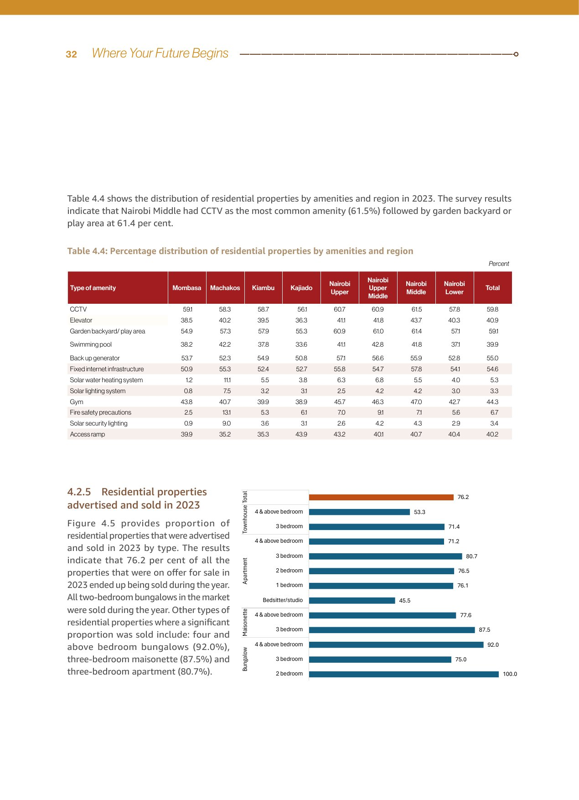

LLM Answer: Based on Table 4.4, "Percentage distribution of residential properties by amenities and region," here are the percentages of houses with various amenities in Kenya (represented by the "Total" column) in 2023:

*   **CCTV:** 59.8%
*   **Elevator:** 40.9%
*   **Garden backyard/play area:** 59.1%
*   **Swimming pool:** 39.9%
*   **Back up generator:** 55.0%
*   **Fixed internet infrastructure:** 54.6%
*   **Solar water heating system:** 5.3%
*   **Solar lighting system:** 3.3%
*   **Gym:** 44.3%
*   **Fire safety precautions:** 6.7%
*   **Solar security lighting:** 3.4%
*   **Access ramp:** 40.2%


'Based on Table 4.4, "Percentage distribution of residential properties by amenities and region," here are the percentages of houses with various amenities in Kenya (represented by the "Total" column) in 2023:\n\n*   **CCTV:** 59.8%\n*   **Elevator:** 40.9%\n*   **Garden backyard/play area:** 59.1%\n*   **Swimming pool:** 39.9%\n*   **Back up generator:** 55.0%\n*   **Fixed internet infrastructure:** 54.6%\n*   **Solar water heating system:** 5.3%\n*   **Solar lighting system:** 3.3%\n*   **Gym:** 44.3%\n*   **Fire safety precautions:** 6.7%\n*   **Solar security lighting:** 3.4%\n*   **Access ramp:** 40.2%'

In [16]:
# Define the query
question = "Will you please tell me about the percentage of houses with amenities in Kenya based on the statistics?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

Question: Whats the percentage distribution of residential houses in Kenya by region?
Most relevant image: real_estate_images/page_029.jpg


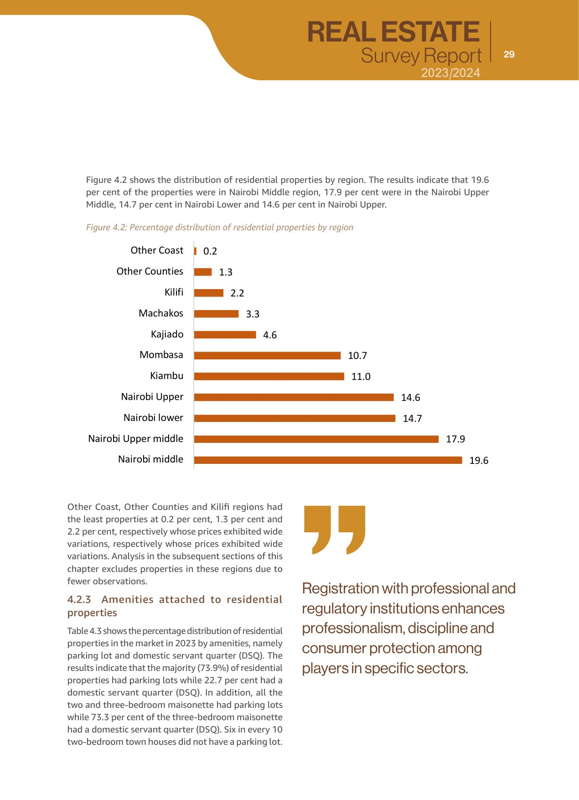

LLM Answer: The percentage distribution of residential houses in Kenya by region is shown in the bar chart and described in the accompanying text.

Here's the breakdown:
*   **Nairobi middle:** 19.6%
*   **Nairobi Upper middle:** 17.9%
*   **Nairobi lower:** 14.7%
*   **Nairobi Upper:** 14.6%
*   **Kiambu:** 11.0%
*   **Mombasa:** 10.7%
*   **Kajiado:** 4.6%
*   **Machakos:** 3.3%
*   **Kilifi:** 2.2%
*   **Other Counties:** 1.3%
*   **Other Coast:** 0.2%


"The percentage distribution of residential houses in Kenya by region is shown in the bar chart and described in the accompanying text.\n\nHere's the breakdown:\n*   **Nairobi middle:** 19.6%\n*   **Nairobi Upper middle:** 17.9%\n*   **Nairobi lower:** 14.7%\n*   **Nairobi Upper:** 14.6%\n*   **Kiambu:** 11.0%\n*   **Mombasa:** 10.7%\n*   **Kajiado:** 4.6%\n*   **Machakos:** 3.3%\n*   **Kilifi:** 2.2%\n*   **Other Counties:** 1.3%\n*   **Other Coast:** 0.2%"

In [17]:
# Define the query
question = "Whats the percentage distribution of residential houses in Kenya by region?"

# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)

Question: Is there any disparity of properties on sale and or being sold, if so which county is in the lead in this?
Most relevant image: real_estate_images/page_051.jpg


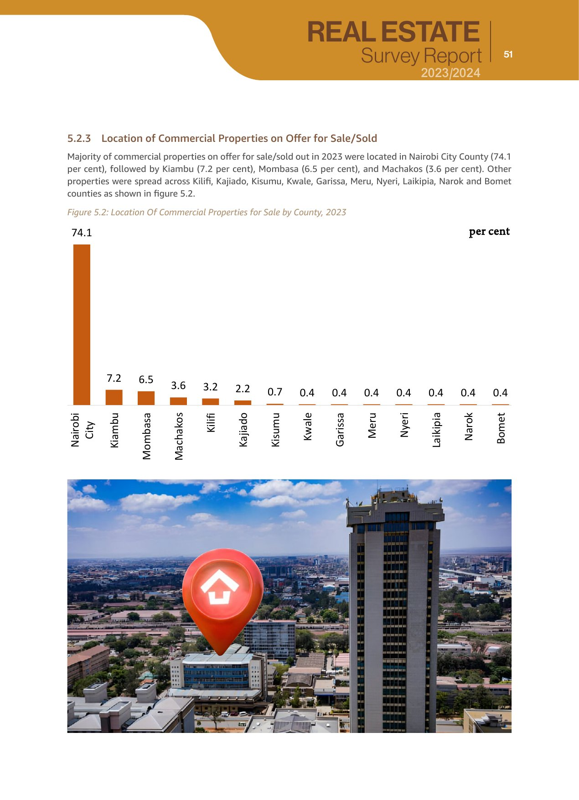

LLM Answer: Yes, there is a significant disparity in the properties on sale and/or being sold among the counties.

Nairobi City County is overwhelmingly in the lead, accounting for 74.1% of the commercial properties on offer for sale/sold in 2023. This is a substantial lead compared to the other counties.

Following Nairobi City County, the percentages for other counties are much lower:
Kiambu: 7.2%
Mombasa: 6.5%
Machakos: 3.6%
Kilifi: 3.2%
Kajiado: 2.2%
Kisumu: 0.7%
Kwale, Garissa, Meru, Nyeri, Laikipia, Narok, and Bomet each account for 0.4%.


'Yes, there is a significant disparity in the properties on sale and/or being sold among the counties.\n\nNairobi City County is overwhelmingly in the lead, accounting for 74.1% of the commercial properties on offer for sale/sold in 2023. This is a substantial lead compared to the other counties.\n\nFollowing Nairobi City County, the percentages for other counties are much lower:\nKiambu: 7.2%\nMombasa: 6.5%\nMachakos: 3.6%\nKilifi: 3.2%\nKajiado: 2.2%\nKisumu: 0.7%\nKwale, Garissa, Meru, Nyeri, Laikipia, Narok, and Bomet each account for 0.4%.'

In [18]:
# Define the query
question = "Is there any disparity of properties on sale and or being sold, if so which county is in the lead in this?"
# Search for the most relevant image
top_image_path = search(question)

# Use the image to answer the query
answer(question, top_image_path)